<>:83: SyntaxWarning: invalid escape sequence '\D'
<>:83: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Hp\AppData\Local\Temp\ipykernel_8052\4062905995.py:83: SyntaxWarning: invalid escape sequence '\D'
  file_path = "D:\Documents\GitHub\Sports Website\AlgoTradingBacktester\data\sudowoodo_prices.csv"


--- Sudowoodo Market Data Analysis ---

1. Mid-Price Analysis (Fair Value Estimation):
count    10000.0
mean     10000.0
std          1.5
min       9996.5
25%      10000.0
50%      10000.0
75%      10000.0
max      10003.5
Name: mid_price, dtype: float64

2. Bid-Ask Spread Analysis (Profit Opportunity):
count    10000.00
mean         6.78
std          2.47
min          2.00
25%          6.00
50%          8.00
75%          8.00
max         10.00
Name: spread, dtype: float64


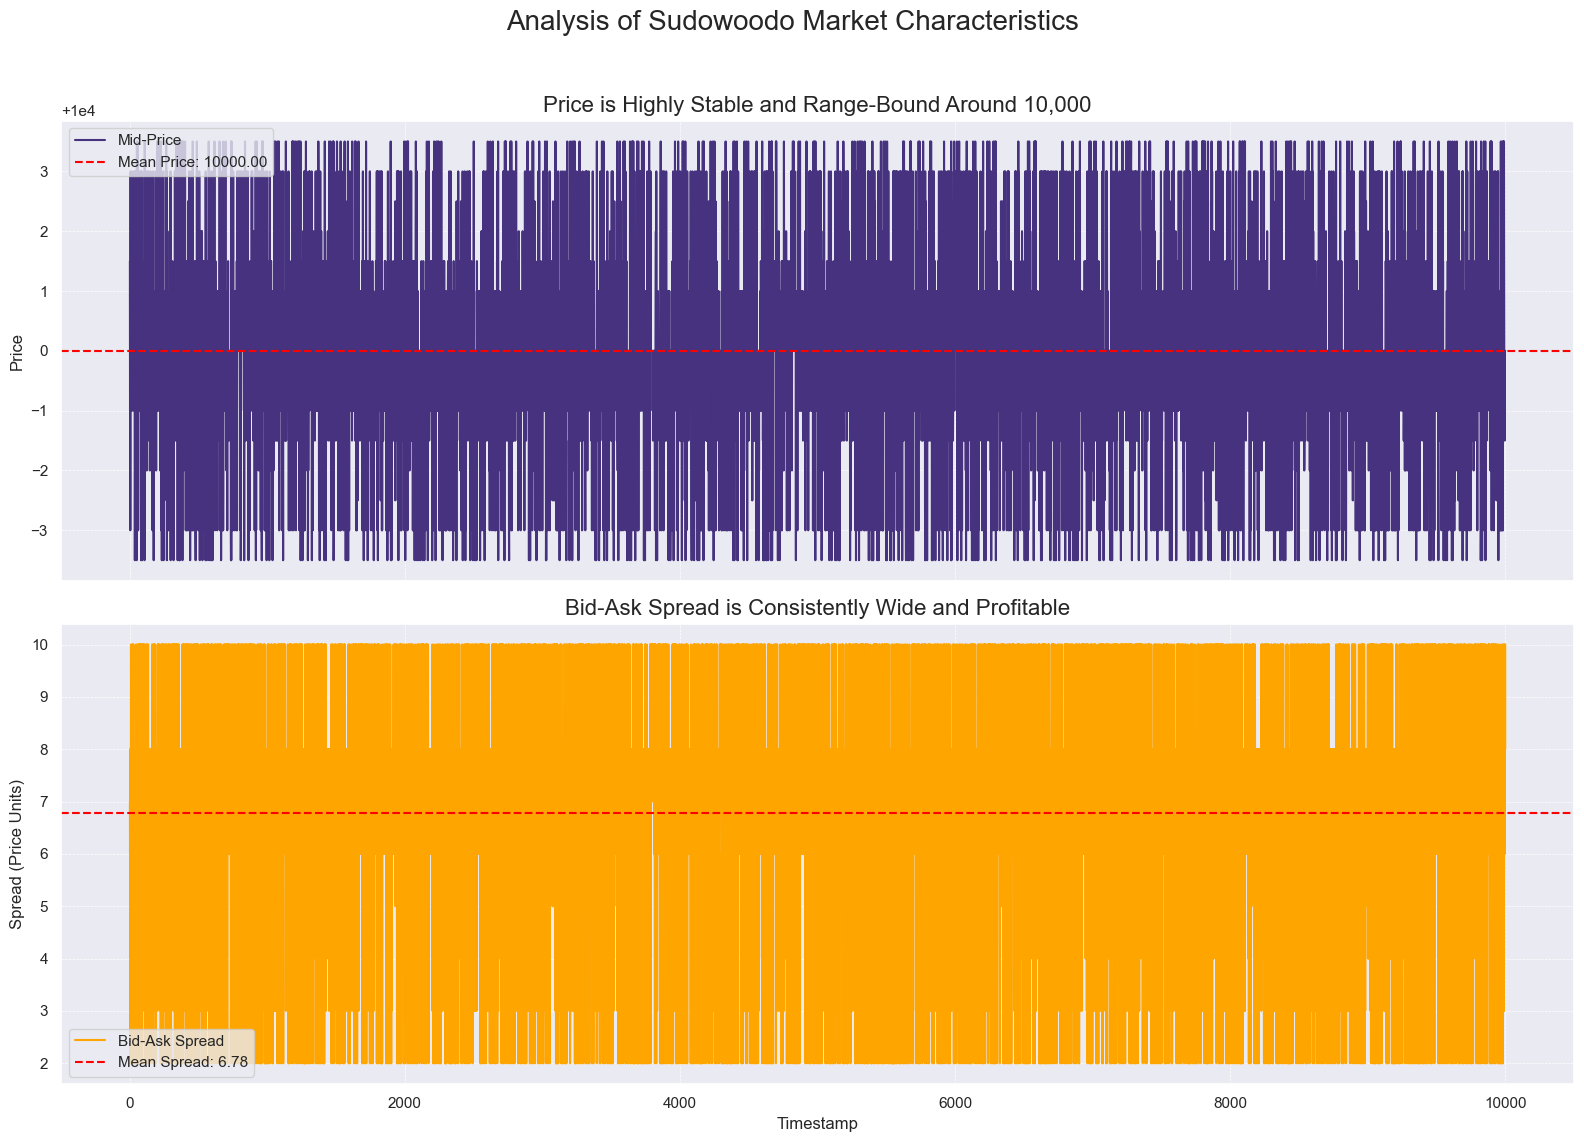


--- Strategic Conclusion ---
The visualizations confirm the statistical findings:
1. Price Stationarity: The price oscillates tightly around a clear mean, minimizing directional risk.
2. Consistent, Wide Spread: The profit opportunity from the spread is reliable and significant.

This combination makes a **Market Making** strategy the ideal choice for this asset.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_market_data(file_path):
    """
    Loads market data from a CSV, calculates key metrics, and visualizes them
    to inform a trading strategy.
    """
    # --- Step 1: Load and Prepare Data ---
    try:
        # Load the market prices data from the provided CSV file.
        prices_df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: '{file_path}' not found. Please ensure the file is in the correct directory.")
        return

    # --- Step 2: Calculate Key Metrics for Analysis ---
    
    # Calculate the mid-price to understand the asset's central tendency.
    prices_df['mid_price'] = (prices_df['bid_price_1'] + prices_df['ask_price_1']) / 2
    
    # Calculate the bid-ask spread to identify profit opportunities.
    prices_df['spread'] = prices_df['ask_price_1'] - prices_df['bid_price_1']

    # --- Step 3: Perform and Print Statistical Analysis ---
    
    print("--- Sudowoodo Market Data Analysis ---")
    print("\n1. Mid-Price Analysis (Fair Value Estimation):")
    # Using .describe() to get a full statistical summary
    print(prices_df['mid_price'].describe().round(2))
    
    print("\n2. Bid-Ask Spread Analysis (Profit Opportunity):")
    print(prices_df['spread'].describe().round(2))

    # --- Step 4: Visualize the Market Characteristics ---
    
    # Set the plotting style for better aesthetics
    sns.set(style="darkgrid", palette="viridis")
    
    # Create a figure to hold our plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
    fig.suptitle('Analysis of Sudowoodo Market Characteristics', fontsize=20, y=0.95)

    # Plot 1: Mid-Price Time Series
    ax1.plot(prices_df['timestamp'], prices_df['mid_price'], label='Mid-Price', linewidth=1.5)
    
    # Add a horizontal line for the mean price to highlight the mean-reversion
    mean_price = prices_df['mid_price'].mean()
    ax1.axhline(y=mean_price, color='red', linestyle='--', label=f'Mean Price: {mean_price:.2f}')
    
    ax1.set_title('Price is Highly Stable and Range-Bound Around 10,000', fontsize=16)
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot 2: Bid-Ask Spread Time Series
    ax2.plot(prices_df['timestamp'], prices_df['spread'], label='Bid-Ask Spread', color='orange', linewidth=1.5)
    
    # Add a horizontal line for the mean spread
    mean_spread = prices_df['spread'].mean()
    ax2.axhline(y=mean_spread, color='red', linestyle='--', label=f'Mean Spread: {mean_spread:.2f}')
    
    ax2.set_title('Bid-Ask Spread is Consistently Wide and Profitable', fontsize=16)
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Spread (Price Units)')
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Display the plots
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    # --- Step 5: Print Conclusive Remarks ---
    print("\n--- Strategic Conclusion ---")
    print("The visualizations confirm the statistical findings:")
    print("1. Price Stationarity: The price oscillates tightly around a clear mean, minimizing directional risk.")
    print("2. Consistent, Wide Spread: The profit opportunity from the spread is reliable and significant.")
    print("\nThis combination makes a **Market Making** strategy the ideal choice for this asset.")

# --- Run the Analysis ---
# Provide the path to your data file.
file_path = "D:\Documents\GitHub\Sports Website\AlgoTradingBacktester\data\sudowoodo_prices.csv"
analyze_market_data(file_path)



In [ ]:
from src.backtester import Order, OrderBook
from typing import List
import numpy as np

class Trader:
    def __init__(self):
        """
        Initializes the Trader with parameters fine-tuned for the Sudowoodo market.
        """
        self.position_limit = 20
        self.order_size = 5
        
        # MODIFIED: Set a wider spread to be profitable but competitive in the Sudowoodo market.
        # The market spread is often ~8-10, so a spread of 4 makes our quotes aggressive.
        self.spread = 4
        
        # MODIFIED: Increased risk aversion to manage inventory more aggressively.
        # This shifts our quote prices more strongly when our position deviates from neutral.
        self.risk_aversion = 2.0
        
        # History for fair value calculation
        self.price_history = []
        self.sma_period = 10

    def run(self, state, current_position):
        """
        This function is called by the backtester on every time step and implements
        the improved market making logic with inventory skewing.
        """
        result = {}
        # The backtester will map "PRODUCT" to the asset being traded (Sudowoodo).
        product = "PRODUCT" 
        orders = []
        order_depth = state.order_depth

        if not order_depth.buy_orders or not order_depth.sell_orders:
            result[product] = orders
            return result

        # --- Fair Value Calculation (Unchanged) ---
        best_bid = max(order_depth.buy_orders.keys())
        best_ask = min(order_depth.sell_orders.keys())
        mid_price = (best_bid + best_ask) / 2
        
        self.price_history.append(mid_price)
        if len(self.price_history) > self.sma_period:
            self.price_history.pop(0)
        
        if len(self.price_history) < self.sma_period:
            result[product] = orders
            return result
            
        fair_value = np.mean(self.price_history)

        # --- Inventory Skewing Logic (Parameters Modified) ---
        
        # 1. Define our ideal bid and ask prices around the fair value using our new spread
        our_bid_price = fair_value - self.spread / 2
        our_ask_price = fair_value + self.spread / 2
        
        # 2. Calculate the inventory skew factor
        inventory_skew = current_position / self.position_limit
        
        # 3. Adjust our prices based on the skew using our new risk_aversion factor
        our_bid_price -= inventory_skew * self.risk_aversion
        our_ask_price -= inventory_skew * self.risk_aversion
        
        # Round to nearest integer price level
        our_bid_price = int(round(our_bid_price))
        our_ask_price = int(round(our_ask_price))

        # --- Order Placement with Skewed Sizes (Unchanged Logic) ---

        if current_position < self.position_limit:
            buy_qty = int(self.order_size * (1 - inventory_skew))
            buy_qty = min(buy_qty, self.position_limit - current_position)
            if buy_qty > 0:
                orders.append(Order(product, our_bid_price, buy_qty))

        if current_position > -self.position_limit:
            sell_qty = int(self.order_size * (1 + inventory_skew))
            sell_qty = min(sell_qty, self.position_limit + current_position)
            if sell_qty > 0:
                orders.append(Order(product, our_ask_price, -sell_qty))
        
        result[product] = orders
        return result


<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\O'
C:\Users\Hp\AppData\Local\Temp\ipykernel_8052\482643360.py:2: SyntaxWarning: invalid escape sequence '\O'
  Image("D:\OneDrive - Indian Institute of Technology Bombay\Pictures\Screenshots\Screenshot 2025-06-15 144158.png", width=1000, height=500)


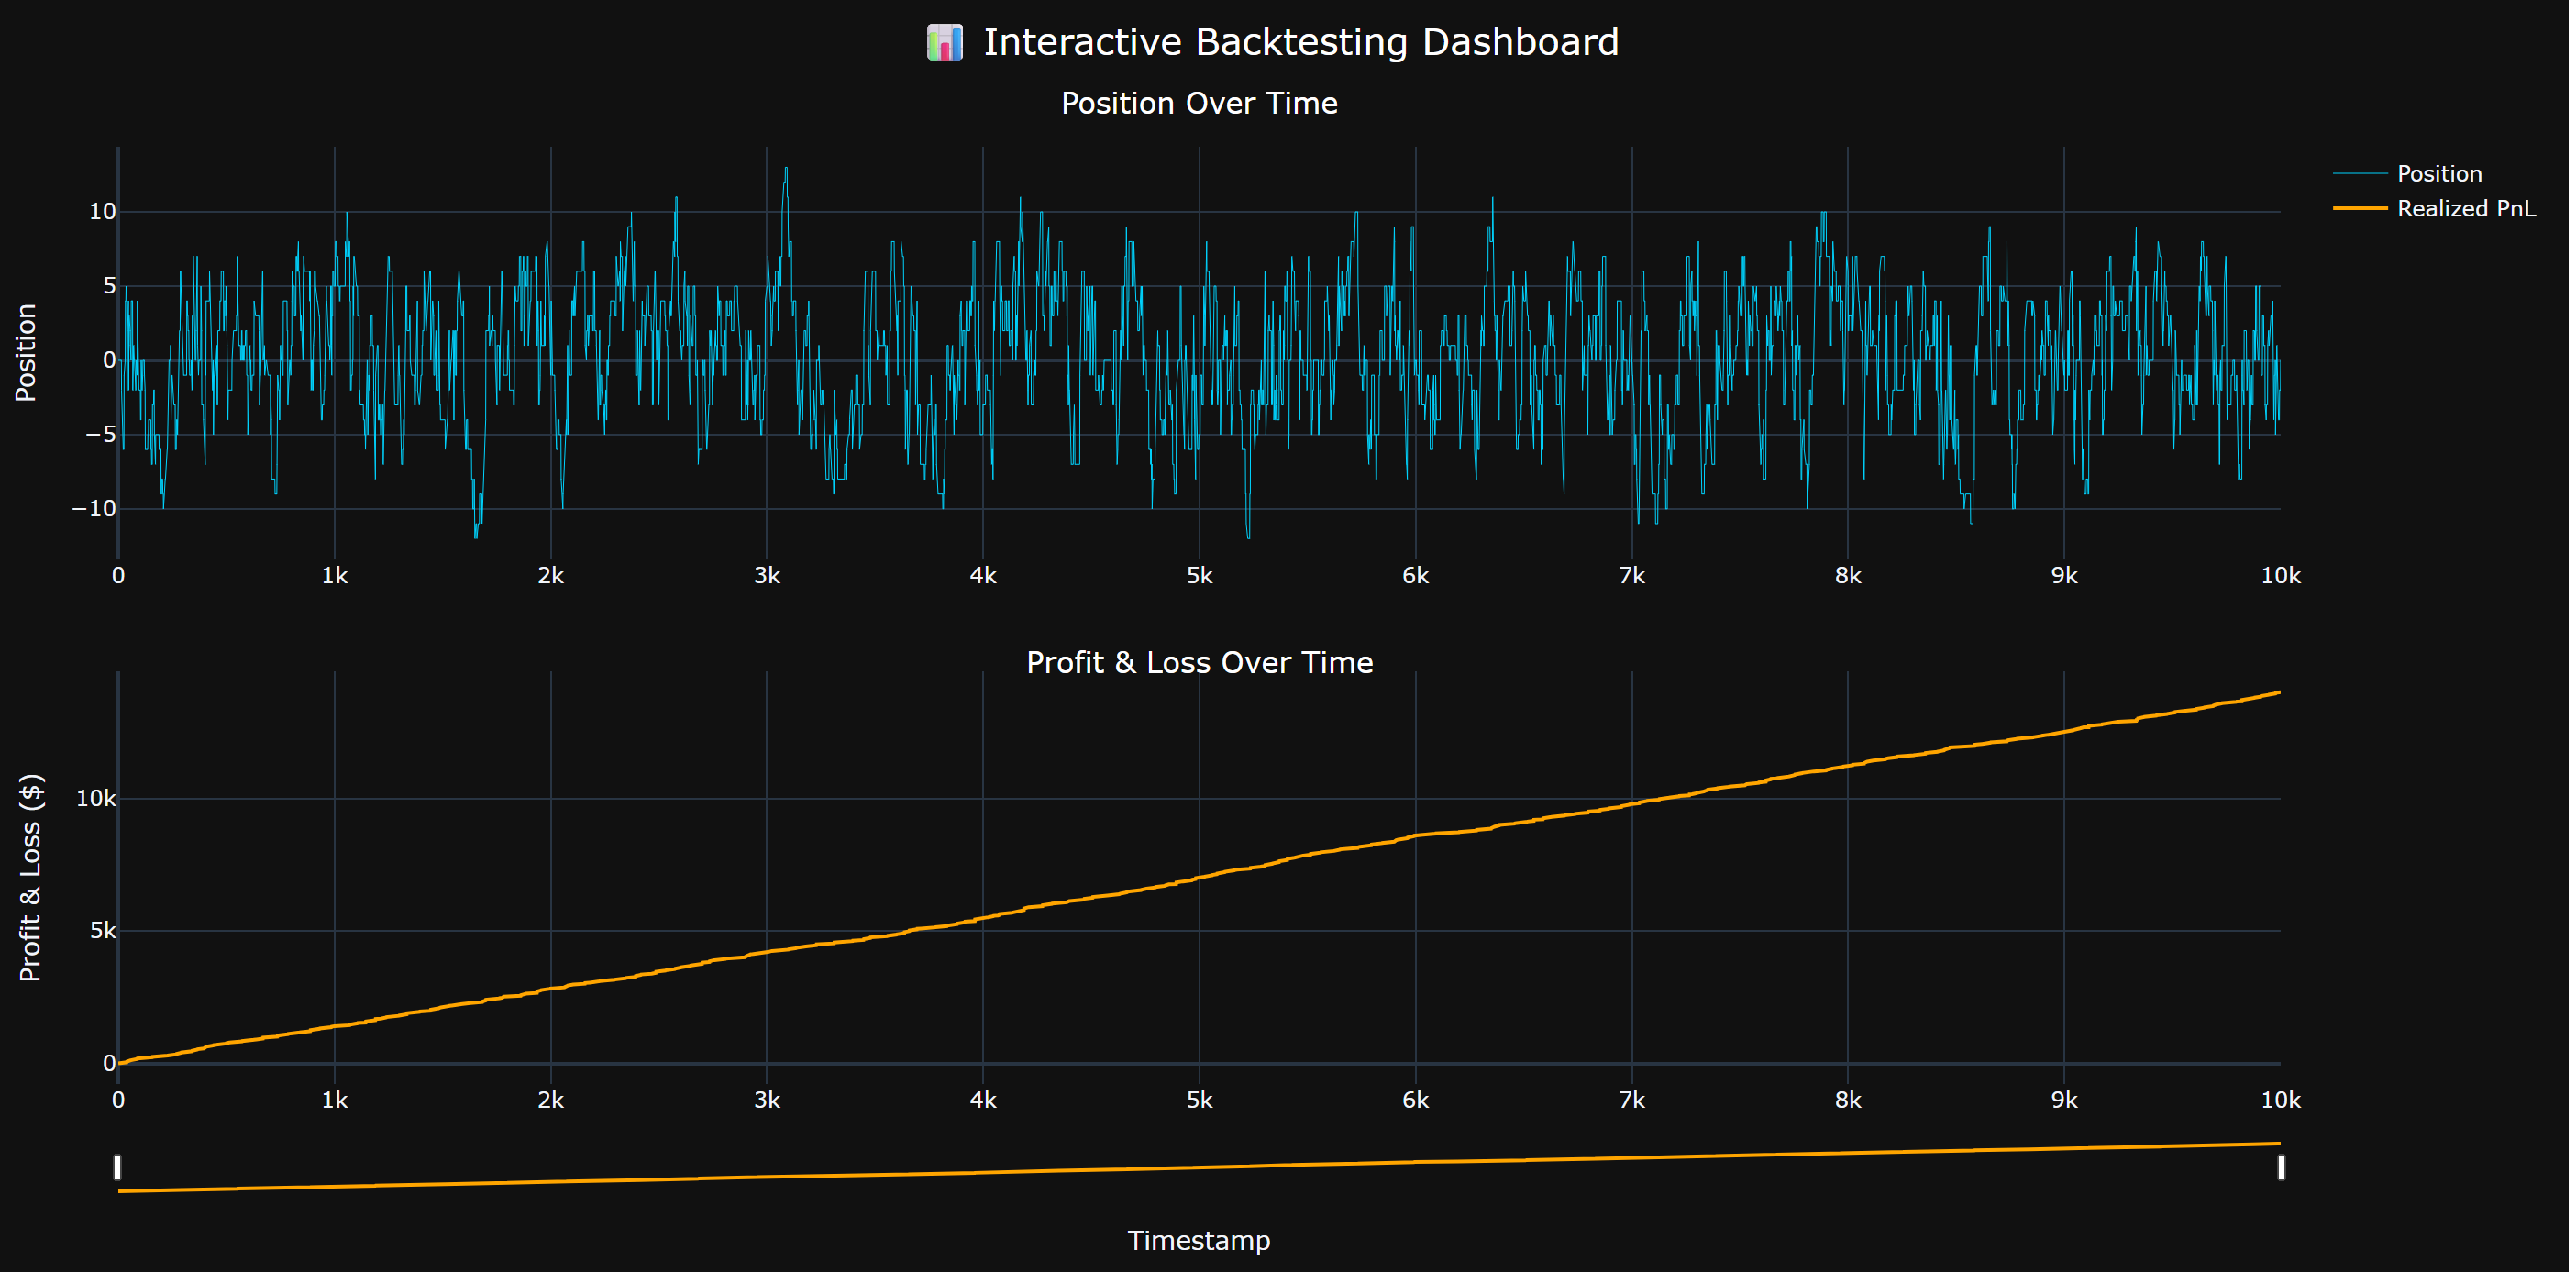

In [3]:
from IPython.display import Image
Image("D:\OneDrive - Indian Institute of Technology Bombay\Pictures\Screenshots\Screenshot 2025-06-15 144158.png", width=1000, height=500)
